# Restless DRAG Calibrations using a restless `DataProcessor`

In this tutorial we demonstrate how we can perform a *restless* DRAG calibration with qiskit-experiments.

**What is a restless experiment?**

Usually, when running circuits on a quantum device, the qubit is reset to the ground state after each measurement to ensure a well-defined initial state for the next circuit. This can be done passively by waiting several $T_1$-times such that the qubit decays due to the interaction with the environment if it was in the excited state. Since the $T_1$-times are continuously being increased (already beyond $100 \mu s$), this initialization procedure becomes time-consuming and inefficient. 
Another more efficient way is to actively reset the qubit - and this is how a qubit is reset on the IBM Quantum devices. This saves time but also lasts a few microseconds.  

However, for several types of experiments, a reset is not needed and we can directly continue with the following circuit after a small delay time, even if the qubit was measured in the excited state. This is the idea of a restless measurement. This tutorial shows that we can perform a restless DRAG calibration which can lead to a reduced experiment duration.

In [1]:
import numpy as np
import pandas as pd

from qiskit import QuantumCircuit, transpile, IBMQ
import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

backend = provider.get_backend('ibmq_jakarta')

The IBM Quantum devices have dynamical repetition delays anabled. This means that we can choose the delay after a circuit in a range of delays, typically 0 to 500$\mu$s. The default value is for most of the devices 250$\mu$s. Our aim will be to set this delay to a small value of 1$\mu$s.

In [2]:
config = backend.configuration()
defaults = backend.defaults()

print('Rep. delay range:', config.rep_delay_range)
print('Default rep. delay:', config.default_rep_delay)

Rep. delay range: [0.0, 0.0005]
Default rep. delay: 0.00025


In [3]:
qubit = 2 # The qubit we will work with

## 1. Standard `RoughDrag` experiment

In [4]:
from qiskit_experiments.library import RoughDrag

In [5]:
x_gate_instruction = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1]
x_pulse = x_gate_instruction.pulse

duration = x_pulse.duration
amp = x_pulse.amp
sigma = x_pulse.sigma

x_pulse

Drag(duration=160, amp=(0.19189367897092854+0j), sigma=40, beta=-1.0348171767307173, name='Xp_d2')

In [7]:
channel = x_gate_instruction.channel
channel

DriveChannel(2)

Since we would like to roughly calibrate the DRAG parameter $\beta$ we define a parametrized DRAG schedule where $\beta$ is our paramater.

In [8]:
with pulse.build(name="xp") as xp:
    pulse.play(pulse.Drag(duration, amp, sigma, Parameter("beta")), channel)
    
xp

ScheduleBlock(Play(Drag(duration=160, amp=(0.19189367897092854+0j), sigma=40, beta=beta), DriveChannel(2)), name="xp", transform=AlignLeft())

We define the standard RoughDrag experiment using our parametrized DRAG pulse.

In [9]:
cal_drag = RoughDrag(qubit, backend=backend, schedule=xp)

cal_drag.set_experiment_options(betas=np.linspace(-20, 20, 25), reps=[3, 5, 7])

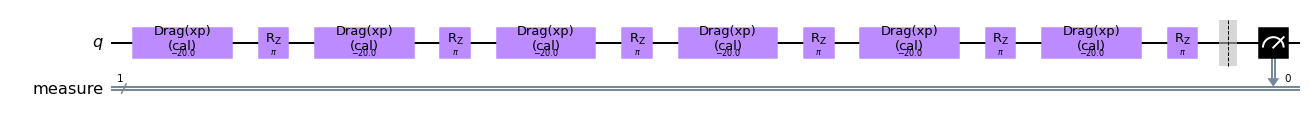

In [10]:
cal_drag.circuits()[0].draw(output='mpl', fold=True)

In [11]:
drag_data = cal_drag.run(backend)

In [15]:
drag_data

<ExperimentData[RoughDrag], backend: ibmq_jakarta, status: DONE, experiment_id: 507d2dbd-0a47-488b-8635-41ee7adbe1cf>

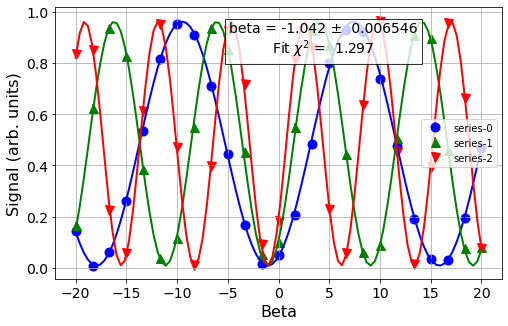

In [16]:
drag_data.figure(0)

In [17]:
print(drag_data.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: -1.0424072700990432 ± 0.006545848802752653
- χ²: 1.2968786230884846
- quality: good
- device_components: ['Q2']
- verified: False


## 2. Restless `RoughDrag`  experiment

### 2.1 We need the following settings to perform a restless `RoughDrag` experiment:

Set the run options:
1. Set the `rep_delay` to a small value, e.g. $1 \mu s$
2. Ensure that the qubit is not reset to the ground state throughout the experiment: `init_qubits=False`

This means that now the circuits are executed without reseting the qubit after a measurement. The subsequent circuit is run after a small delay time.

In [18]:
restless_cal_drag = RoughDrag(qubit, backend=backend, schedule=xp)

restless_cal_drag.set_experiment_options(betas=np.linspace(-20, 20, 25), reps=[3, 5, 7])

# set restless run options.
restless_cal_drag.set_run_options(rep_delay=1e-6, meas_level=2, memory=True, init_qubits=False)

In [19]:
restless_drag_data = restless_cal_drag.run(backend)

In [22]:
restless_drag_data

<ExperimentData[RoughDrag], backend: ibmq_jakarta, status: DONE, experiment_id: 77b457b5-b7be-4e73-8e55-7a446bffbea2>

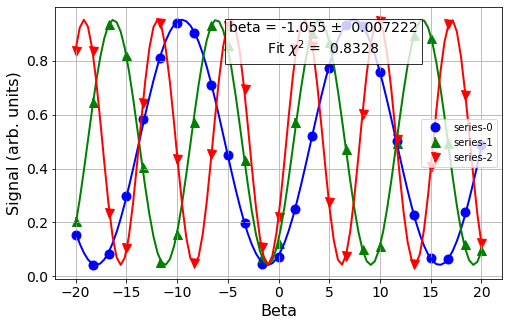

In [23]:
restless_drag_data.figure(0)

In [24]:
print(restless_drag_data.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: -1.0553405047062412 ± 0.007222020077430766
- χ²: 0.8328234993126662
- quality: good
- device_components: ['Q2']
- verified: False


### How does this restless `DataProcessor` work?

All single counts are classified: If the measurement outcome of circuit n is the same as the outcome of circuit n-1, we label the outcome of circuit n as a "1" and if they differ, as a "0". This data is then analysed by running the standard DRAG calibration analysis. 

### 2.2 Consistency check: run a restless `RoughDrag` experiment and use the standard data processor

In [28]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.nodes import Probability

In [29]:
restless_cal_drag_no_processor = RoughDrag(qubit, backend=backend, schedule=xp)

restless_cal_drag_no_processor.set_experiment_options(betas=np.linspace(-20, 20, 25), reps=[3, 5, 7])

# set restless run options.
restless_cal_drag_no_processor.set_run_options(rep_delay=1e-6, meas_level=2, memory=True, init_qubits=False)

# standard data processor.
standard_processor = DataProcessor("counts", [Probability("1")])
restless_cal_drag_no_processor.set_analysis_options(data_processor=standard_processor)

In [30]:
restless_drag_no_processor_data = restless_cal_drag_no_processor.run(backend)

In [37]:
restless_drag_no_processor_data

<ExperimentData[RoughDrag], backend: ibmq_jakarta, status: DONE, experiment_id: ec57c2aa-704a-4bb9-97fb-d447d7537d1c>

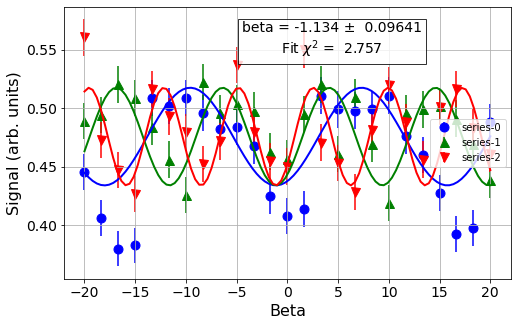

In [38]:
restless_drag_no_processor_data.figure(0)

In [39]:
print(restless_drag_no_processor_data.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: -1.1337413649408226 ± 0.09641396680509907
- χ²: 2.757178472117525
- quality: good
- device_components: ['Q2']
- verified: False


## 3. Compare the results and job runtimes

Results of the experiments:

**Standard DRAG calibration**: $\beta = -1.042 \pm 0.007$

**Restless DRAG calibration**: $\beta = -1.055 \pm 0.007$

In [41]:
job = backend.retrieve_job(drag_data.job_ids[0])
job_restless = backend.retrieve_job(restless_drag_data.job_ids[0])
print(f'Job duration for standard DRAG calibration: {job.result().time_taken}s')
print(f'Job duration for restless DRAG calibration: {job_restless.result().time_taken}s')

### We observe a significant job duration reduction!

Note that `job.result().time_taken` does not only contain the circuit execution time but also, e.g. loading the job.